# Final Project - Predicting Mushroom Toxicity

### DATA 201

### Authors: Hannah Marr, Sydney Bulatao, Tiffany Xie

## Initial Data Pre-processing

In [2]:
#pip install ucimlrepo

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 

In [4]:
# metadata 
import pprint
pprint.pprint(mushroom.metadata) 

{'abstract': 'From Audobon Society Field Guide; mushrooms described in terms '
             'of physical characteristics; classification: poisonous or edible',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'This data set includes descriptions of '
                                'hypothetical samples corresponding to 23 '
                                'species of gilled mushrooms in the Agaricus '
                                'and Lepiota Family (pp. 500-525).  Each '
                                'species is identified as definitely edible, '
                                'definitely poisonous, or of unknown edibility '
                                'and not recommended. 

Now that we have downloaded this dataset and its metadata from the UC Irvine Machine Learning repo, we can proceed with exploratory data analysis.

In [5]:
# Combine features and target into a single dataframe
# Ensure 'y' is a Series and give it a name if needed
y.name = 'Target'
df = pd.concat([X, y], axis=1)

# Display the dataframe
df.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [45]:
# Save DataFrame to local csv
# Save the dataframe to a CSV file
df.to_csv('mushroom_data.csv', index=False)

---

## Exploratory Data Analysis

/var/folders/1p/m5frxr_n1c19zhr2wxwwrclh0000gn/T/ipykernel_89639/1192317362.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='poisonous', palette="husl")


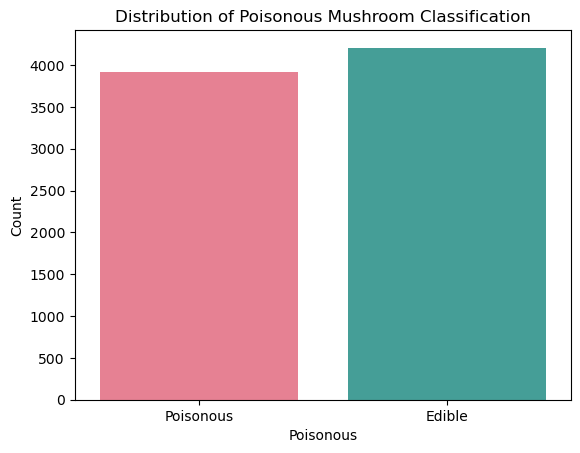

In [47]:
# Distribution of poisonous vs. edible classification
sns.countplot(data=df, x='poisonous', palette="husl")
plt.xlabel('Poisonous')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(0,2,1), labels=['Poisonous', 'Edible'])
plt.title("Distribution of Poisonous Mushroom Classification")
plt.show()

There are slightly more mushrooms classified as edible, so we will need to balance our dataset before training our models later on.

Note - Code below based off of this tutorial: https://www.geeksforgeeks.org/calculate-cramer-s-coefficient-matrix-using-pandas/

In [6]:
# Feature correlation matrix
from scipy.stats import chi2_contingency

def cramers_v(x, y):
  contingency_table = pd.crosstab(x, y)
  chi2_statistic, p_value, dof, expected = chi2_contingency(contingency_table)

  # Calculate Cramer's V
  n = contingency_table.sum().sum()
  phi2 = chi2_statistic / n
  r, k = contingency_table.shape
  phi2corr = max(0, phi2 - ((k-1) * (r-1)) / (n-1))
  k_corr = k - (k-1) * (k-2) / (n-1)
  r_corr = r - (r-1) * (r-2) / (n-1)
  v = np.sqrt(phi2corr / min(k_corr - 1, r_corr - 1))

  return v

features = (X.columns).drop('veil-type') # Cramer's V could not be calculated for veil-type
cramers_v_matrix = pd.DataFrame(index=features, columns=features)

# Calculate Cramer's V for each pair of variables in the matrix 
for var1 in features:
  for var2 in features:
    cramers_v_matrix.loc[var1, var2] = cramers_v(X[var1], X[var2])

In [7]:
cramers_v_matrix

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
cap-shape,0.999938,0.20223,0.16821,0.254399,0.243562,0.152979,0.077844,0.345935,0.232259,0.3061,...,0.15814,0.10948,0.212414,0.167523,0.22311,0.197871,0.206736,0.249086,0.240059,0.269825
cap-surface,0.20223,0.999938,0.222828,0.132995,0.236401,0.209964,0.337676,0.276748,0.255007,0.07639,...,0.142852,0.16832,0.250545,0.255563,0.133005,0.097272,0.223655,0.230525,0.260936,0.249562
cap-color,0.16821,0.222828,0.999938,0.215087,0.330496,0.245721,0.398569,0.469128,0.280161,0.594462,...,0.254946,0.318438,0.274646,0.277386,0.147221,0.336107,0.557183,0.284697,0.304066,0.325179
bruises,0.254399,0.132995,0.215087,0.999685,0.66016,0.136121,0.298928,0.369159,0.649284,0.098489,...,0.574863,0.566406,0.482206,0.491838,0.132579,0.069369,0.768171,0.611585,0.29955,0.530224
odor,0.243562,0.236401,0.330496,0.66016,0.999938,0.259907,0.42862,0.760271,0.388688,0.574987,...,0.415219,0.506364,0.449302,0.445768,0.099889,0.742204,0.696336,0.395316,0.373675,0.368838
gill-attachment,0.152979,0.209964,0.245721,0.136121,0.259907,0.997494,0.069556,0.107574,0.779292,0.18537,...,0.092617,0.123206,0.977252,0.977252,0.954904,0.20317,0.24976,0.826303,0.413336,0.43568
gill-spacing,0.077844,0.337676,0.398569,0.298928,0.42862,0.069556,0.999484,0.107399,0.32367,0.07979,...,0.436845,0.414425,0.399922,0.374193,0.096763,0.245158,0.289465,0.306999,0.673492,0.541927
gill-size,0.345935,0.276748,0.469128,0.369159,0.760271,0.107574,0.107399,0.99965,0.7832,0.21402,...,0.168971,0.149688,0.364731,0.345751,0.11234,0.194351,0.570221,0.659934,0.517217,0.498585
gill-color,0.232259,0.255007,0.280161,0.649284,0.388688,0.779292,0.32367,0.7832,0.999938,0.611254,...,0.351987,0.37623,0.419518,0.415639,0.451987,0.442797,0.517311,0.484053,0.423487,0.457184
stalk-shape,0.3061,0.07639,0.594462,0.098489,0.574987,0.18537,0.07979,0.21402,0.611254,0.999688,...,0.319452,0.367647,0.536051,0.548746,0.180857,0.33327,0.614754,0.458386,0.455458,0.417076


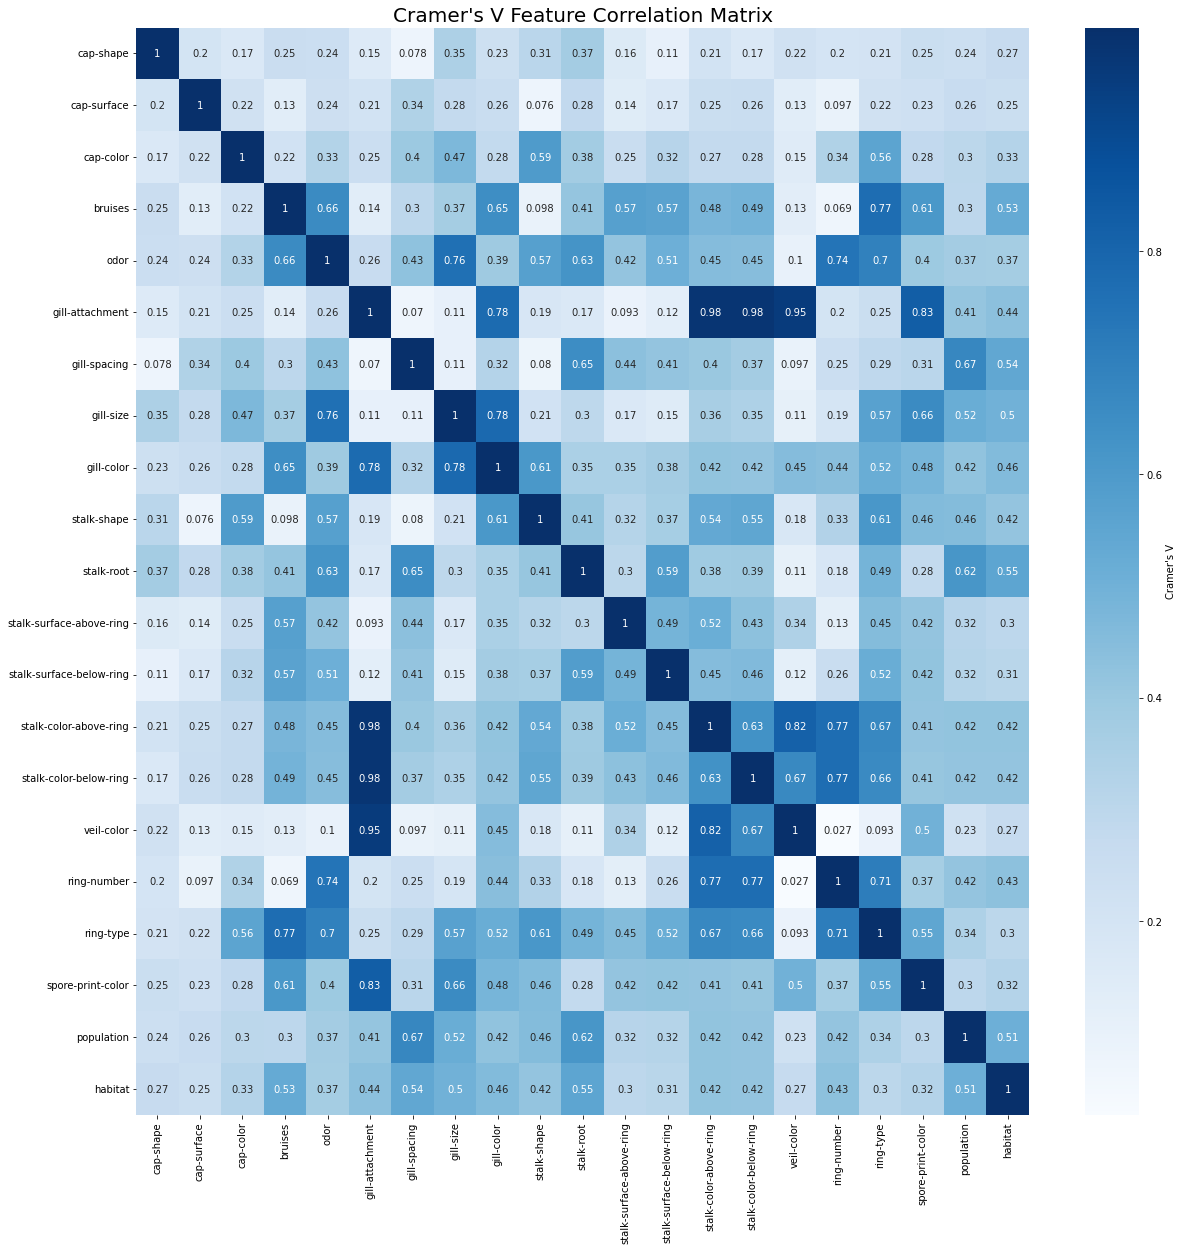

In [8]:
# Visualize
plt.figure(figsize=(20, 20))
sns.heatmap(cramers_v_matrix.astype(float), cmap="Blues", annot=True, cbar_kws={'label': 'Cramer\'s V'})
plt.title("Cramer's V Feature Correlation Matrix", fontsize=20)
plt.xticks(np.arange(0.5, 21.5), cramers_v_matrix.columns)
plt.yticks(np.arange(0.5,21.5), cramers_v_matrix.columns)
plt.show()

We computed the Cramer's Coefficient matrix to better understand the correlation between all of our categorical features. Cramer's V gives us a numeric metric to measure how strong the correlation is between categories. 0 corresponds to no association and 1 corresponds to perfect association. We can see that there are very strong correlations between gill-attachment and stalk-color-above-ring, stalk-color-below-ring, and veil-color. 

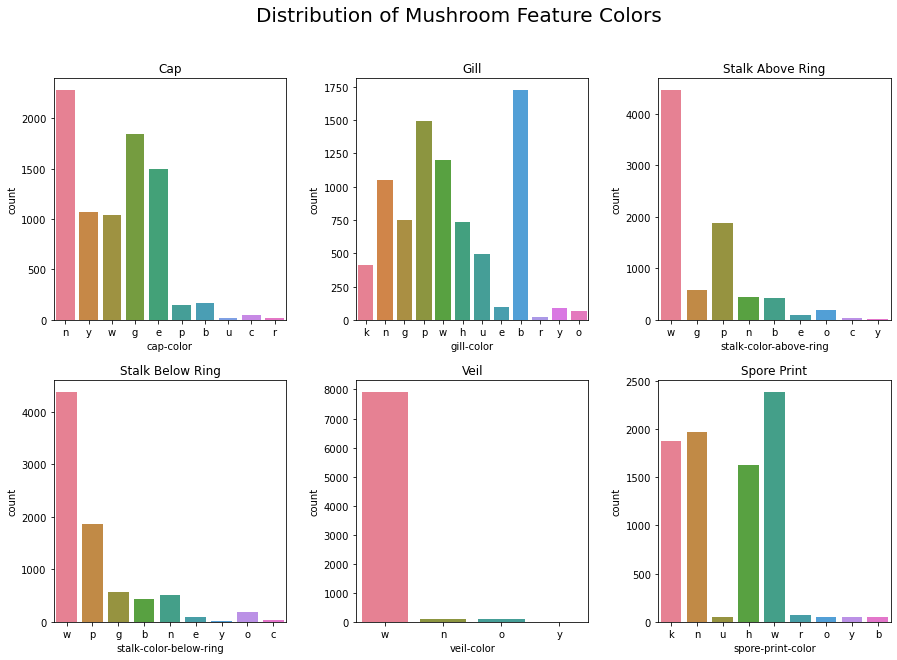

In [28]:
# Distribution of feature colors
features = [['cap-color', 'gill-color', 'stalk-color-above-ring'], ['stalk-color-below-ring', 'veil-color', 'spore-print-color']]
titles = [['Cap', 'Gill', 'Stalk Above Ring'], ['Stalk Below Ring', 'Veil', 'Spore Print']]
fig, ax = plt.subplots(2, 3, figsize=(15,10))

# Loop through the features to plot histograms
for row in range(0,2,1):
  for col in range(0,3,1):
    feature = features[row][col]
    curr_ax = ax[row][col]
    sns.countplot(data=df, x=feature, palette='husl', ax=curr_ax)
    curr_ax.set_title(titles[row][col])

fig.suptitle("Distribution of Mushroom Feature Colors", fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.show()

The cap and gill colors throughout the dataset vary the most. The veil color for the majority of the samples in the dataset is white. For each feature, there are some colors that occur in very low numbers throughout the data. It will be interesting to see if these more sparse/rare feature colors end up corresponding more to poisonous mushrooms. 

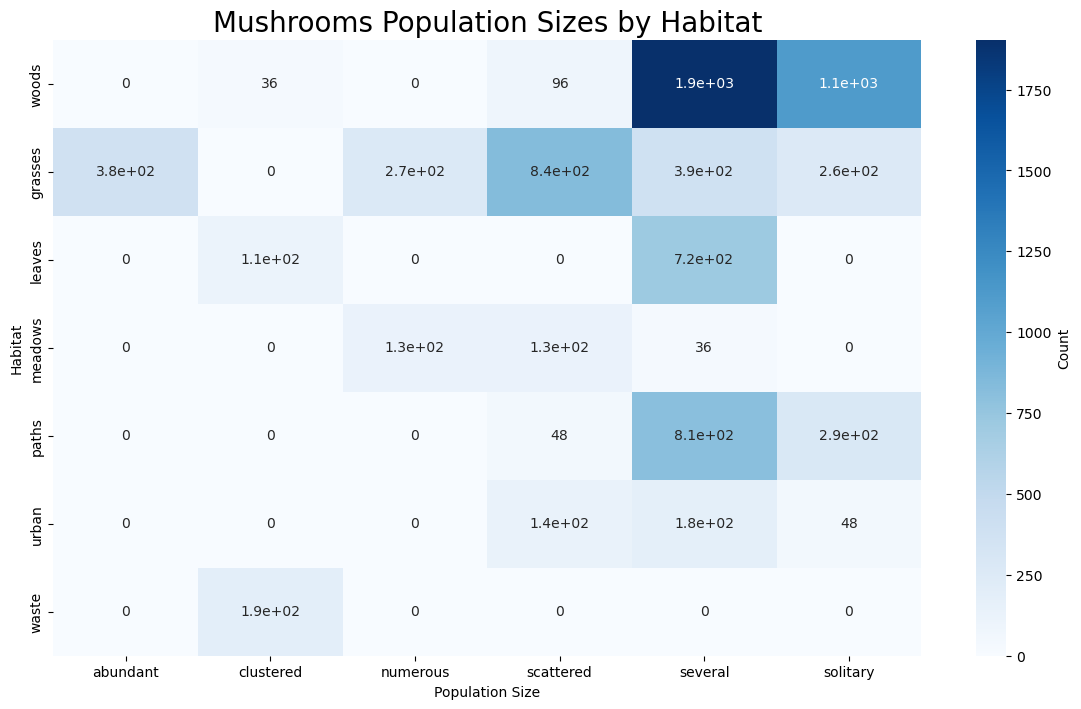

In [51]:
# Mushroom populations by habitat
# Calculate the counts for each population by habitat group
population_by_habitat = df.groupby(['habitat', 'population']).size().unstack().fillna(0)

# Plot as a heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(population_by_habitat, cmap="Blues", annot=True, cbar_kws={'label': 'Count'})
plt.title("Mushrooms Population Sizes by Habitat", fontsize=20)
plt.xlabel("Population Size")
plt.ylabel("Habitat")
plt.xticks(np.arange(0.5,6.5), ['abundant', 'clustered', 'numerous', 'scattered', 'several', 'solitary'])
plt.yticks(np.arange(0.5,7.5), ['woods', 'grasses', 'leaves', 'meadows', 'paths', 'urban', 'waste'])
plt.show()

Most of the mushrooms in the dataset have a population size of "several" and are found in the woods. There are a few combinations of population size and habitat that have very low numbers of mushrooms. These combinations include several & meadows, solitary & urban, several & meadows, and clustered & woods.

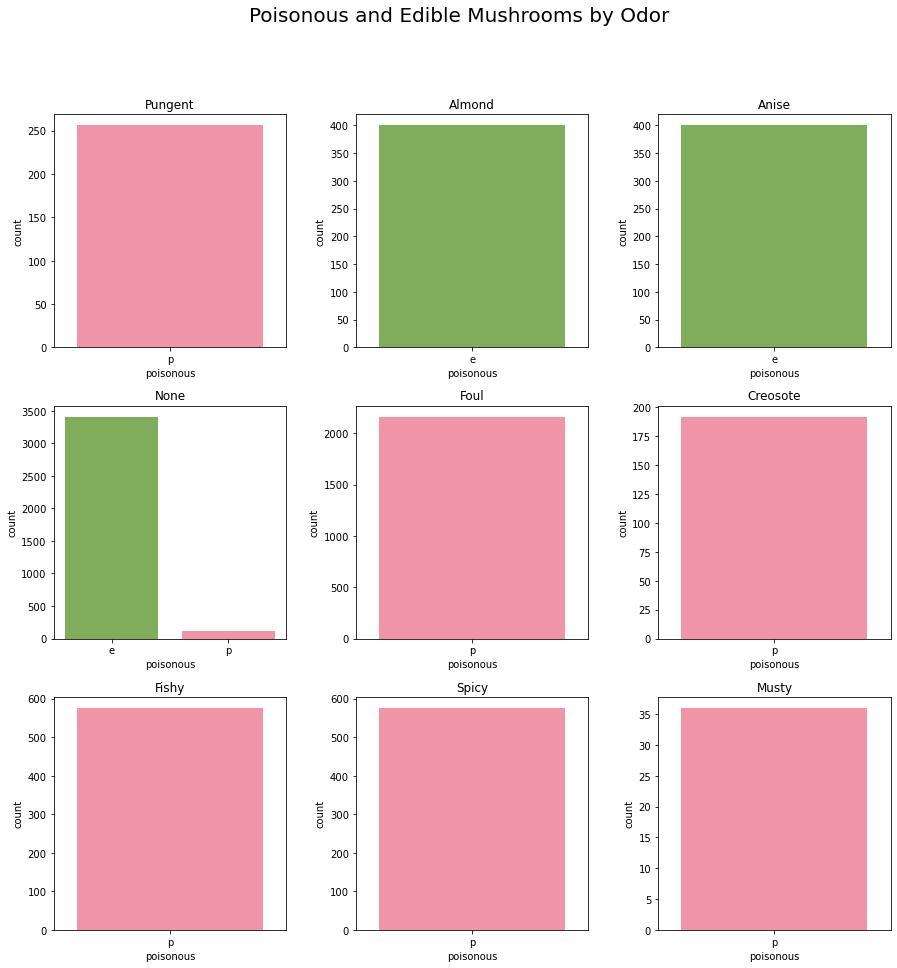

In [27]:
# Distribution of poisonous/edible mushrooms based on odor
# Set up figure
fig, ax = plt.subplots(3, 3, figsize=(15,15))

# Plot for each odor
odors = [['p', 'a', 'l'], ['n', 'f', 'c'], ['y', 's', 'm']]
titles = [['Pungent', 'Almond', 'Anise'], ['None', 'Foul', 'Creosote'], ['Fishy', 'Spicy', 'Musty']]
palette = {'p': '#ff85a0', 'e': '#7ebb4f'}
for row in range(0,3,1):
  for col in range(0,3,1):
    odor = odors[row][col]
    curr_ax = ax[row][col]
    sns.countplot(data=df[df['odor'] == odor], x='poisonous', palette=palette, ax=curr_ax)
    curr_ax.set_title(titles[row][col])

fig.suptitle("Poisonous and Edible Mushrooms by Odor", fontsize=20)
plt.subplots_adjust(wspace=0.3, hspace=0.25)
plt.show()

Most mushroom odors only contain all poisonous or all edible mushrooms, so this feature may be a good one to use in classification. All mushrooms with an almond or anise odor in this dataset are edible. All mushrooms with a musty, spicy, fishy, creosote, foul, or pungent odor in this dataset are poisonous. Mushrooms in this dataset with no odor are mostly edible, but some are poisonous.

---

# SVM Model

## 1. Loading and Preprocessing Data

In [53]:
import pandas as pd
import numpy as np

# Make a copy of the dataset for use in the SVM model
df_SVM = df.copy()

# Step 1: Display basic info about the dataset to inspect structure and check for missing values
df_SVM_info = {
    "head": df_SVM.head(),
    "info": df_SVM.info(),
    "missing_values": df_SVM.isnull().sum()
}

df_SVM_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

{'head':   cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
 0         x           s         n       t    p               f            c   
 1         x           s         y       t    a               f            c   
 2         b           s         w       t    l               f            c   
 3         x           y         w       t    p               f            c   
 4         x           s         g       f    n               f            w   
 
   gill-size gill-color stalk-shape  ... stalk-color-above-ring  \
 0         n          k           e  ...                      w   
 1         b          k           e  ...                      w   
 2         b          n           e  ...                      w   
 3         n          n           e  ...                      w   
 4         b          k           t  ...                      w   
 
   stalk-color-below-ring veil-type veil-color ring-number ring-type  \
 0                      w         

The dataset has 23 columns and 8124 rows. Here are the notable points:
1. Missing Values: The column stalk-root has 2480 missing values. The documentation informs us that missing values are represented by '?' in this dataset.
2. Data Types: All columns are categorical (object dtype), including the target variable, poisonous.
3. Target Column: The poisonous column indicates whether a mushroom is poisonous (p) or edible (e).

In [55]:
# Step 2: Replace '?' with np.nan and handle missing values
# Reason: '?' is not a valid value, and replacing it with np.nan ensures proper handling
df_SVM['stalk-root'] = df_SVM['stalk-root'].replace('?', np.nan)

In [57]:
# Apply imputation with SimpleImputer and flatten the output
from sklearn.impute import SimpleImputer

# Initialize the imputer
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation with SimpleImputer and flatten the output
df_SVM['stalk-root'] = imputer.fit_transform(df_SVM[['stalk-root']]).ravel()

# Verify if missing values have been handled correctly
missing_values_check = df_SVM['stalk-root'].isnull().sum()
unique_values_check = df_SVM['stalk-root'].unique()

# Output the verification results
results = {
    "missing_values_after_fix": missing_values_check,
    "unique_values_in_stalk_root_after_fix": unique_values_check.tolist()
}
print(results)

{'missing_values_after_fix': 0, 'unique_values_in_stalk_root_after_fix': ['e', 'c', 'b', 'r']}


In [59]:
# Step 3: Encode the target variable ('poisonous')
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Convert target values to numerical format for SVM
df_SVM['poisonous'] = label_encoder.fit_transform(df_SVM['poisonous'])

In [61]:
# Step 4: Split features and target
X_final = df_SVM.drop(columns=['poisonous'])
y_final = df_SVM['poisonous']

# Check the shapes of features and target
shape_check_before_encoding_final = (X_final.shape, y_final.shape)

shape_check_before_encoding_final

((8124, 22), (8124,))

In [63]:
# Step 5: One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Convert categorical variables into numeric representations
X_encoded_final = encoder.fit_transform(X_final)

# Check the shape after encoding
shape_check_after_encoding_final = X_encoded_final.shape

shape_check_after_encoding_final

(8124, 116)

In [67]:
# Step 6: Split the dataset into training and testing sets

from sklearn.model_selection import train_test_split  # Import train_test_split

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_encoded_final, y_final, test_size=0.2, random_state=42
)

# Check the shapes of the train and test datasets
train_test_shapes_final = (X_train_final.shape, X_test_final.shape, y_train_final.shape, y_test_final.shape)

train_test_shapes_final

((6499, 116), (1625, 116), (6499,), (1625,))

In [69]:
# Step 7: Scale the features
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the features
X_train_scaled_final = scaler.fit_transform(X_train_final)
X_test_scaled_final = scaler.transform(X_test_final)

---

## 2. SVM Model Implementation

In [71]:
# Step 8: Train the SVM model
from sklearn.svm import SVC

# Initialize and train the SVM model
svm_model_final = SVC(kernel='rbf', random_state=42)
svm_model_final.fit(X_train_scaled_final, y_train_final)

SVC(random_state=42)

In [73]:
# Step 9: Make predictions on the test set
y_pred_final = svm_model_final.predict(X_test_scaled_final)

In [75]:
# Step 10: Evaluate the model's performance
from sklearn.metrics import accuracy_score, classification_report

accuracy_final = accuracy_score(y_test_final, y_pred_final)
classification_report_final = classification_report(y_test_final, y_pred_final)

# Output final results
# Convert the classification report into a DataFrame
classification_report_dict = classification_report(y_test_final, y_pred_final, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Round metrics to 2 decimal places for better readability
classification_report_df = classification_report_df.round(2)

classification_report_df

,precision,recall,f1-score,support
0,1.0,1.0,1.0,843.0
1,1.0,1.0,1.0,782.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1625.0
weighted avg,1.0,1.0,1.0,1625.0


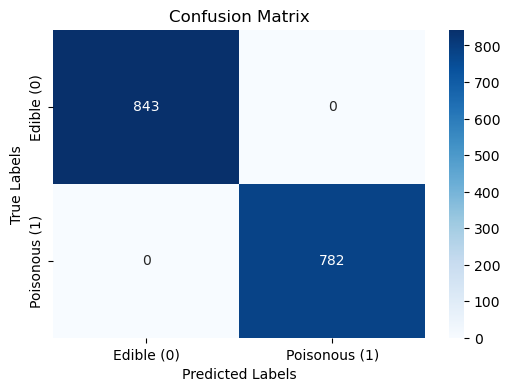

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred_final)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Edible (0)', 'Poisonous (1)'], 
            yticklabels=['Edible (0)', 'Poisonous (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

---

## 3. Tuning the Model

This model does not need tuning, for the following reasons:

1. Perfect Performance: The model achieves 100% accuracy and perfect precision, recall, and F1-scores for both classes. This indicates that it is already separating the classes flawlessly.
2. Dataset Separability: The mushroom dataset is well-structured and highly separable, with features that clearly distinguish between edible and poisonous mushrooms. This means the default hyperparameters of the SVM are likely sufficient to achieve optimal performance.
3. Overfitting Check: If we see such high performance on both training and test sets, it is a strong indicator that the model is not overfitting and no further tuning is necessary.

When tuning might be considered:

* If the dataset were noisier or had ambiguous features, or if the performance on the test set was lower than expected, we might tune parameters like:
* C: Regularization strength.
* kernel: Choice of kernel function (e.g., linear, poly, rbf).
* gamma: Kernel coefficient for rbf, poly, and sigmoid kernels.

---

## 4. Verification of Robustness Using Cross-Validation

In [79]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation to verify robustness
cross_val_scores = cross_val_score(svm_model_final, X_train_scaled_final, y_train_final, cv=5, scoring='accuracy')

# Calculate mean and standard deviation of the cross-validation scores
mean_cv_score = cross_val_scores.mean()
std_cv_score = cross_val_scores.std()

{
    "cross_val_scores": cross_val_scores.tolist(),
    "mean_cv_score": mean_cv_score,
    "std_cv_score": std_cv_score,
    "comment": "Cross-validation confirms model robustness if mean accuracy is high with low standard deviation."
}

{'cross_val_scores': [1.0, 1.0, 0.9984615384615385, 1.0, 0.9976905311778291],
 'mean_cv_score': 0.9992304139278735,
 'std_cv_score': 0.0009735703912762894,
 'comment': 'Cross-validation confirms model robustness if mean accuracy is high with low standard deviation.'}

Cross-Validation Results:

1. Cross-Validation Scores: Individual fold accuracies: [1.0, 1.0, 0.9985, 1.0, 0.9977]
2. Mean Accuracy: 99.92%: Indicates consistently excellent performance across folds.
3. Standard Deviation: 0.097%: Very low variability, demonstrating the model's stability and robustness.

Conclusion:

The model is robust and performs consistently well across different subsets of the training data. Tuning is unnecessary, as the default settings provide near-perfect results.

---

## 5. Visualizations

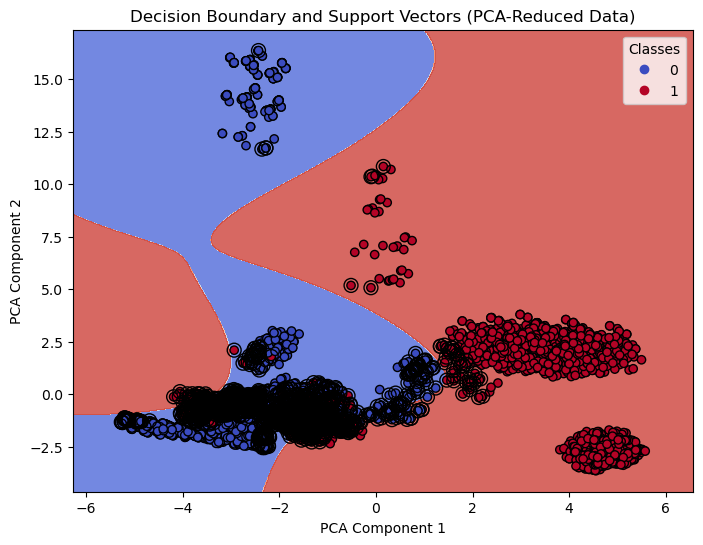

In [81]:
from sklearn.decomposition import PCA
import numpy as np

# Step 1: Reduce data to 2 dimensions using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled_final)
X_test_pca = pca.transform(X_test_scaled_final)

# Step 2: Train an SVM on the reduced data for visualization purposes
svm_model_pca = SVC(kernel='rbf', random_state=42)
svm_model_pca.fit(X_train_pca, y_train_final)

# Step 3: Plot decision boundaries
# Create a mesh grid for visualization
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict on the grid
Z = svm_model_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_final, edgecolors='k', cmap=plt.cm.coolwarm)
plt.scatter(svm_model_pca.support_vectors_[:, 0], svm_model_pca.support_vectors_[:, 1], 
            s=100, facecolors='none', edgecolors='k', label='Support Vectors')
plt.title("Decision Boundary and Support Vectors (PCA-Reduced Data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

This figure visualizes the decision boundary and support vectors of an SVM classifier trained on PCA-reduced data. Below are the key observations and insights derived from this figure:

1. Decision Boundary
* The decision boundary is represented by the curved contour separating the red and blue regions.
* It shows the areas in the PCA-reduced space that the SVM classifies as belonging to Class 0 (edible - blue) or Class 1 (poisonous - red).
* The boundary's non-linear shape reflects the use of the RBF kernel, which captures complex class separations.

2. Class Distribution
* The data points for Class 0 (edible) and Class 1 (poisonous) are mostly well-separated in the PCA space.
* However, there are areas where the classes overlap (e.g., near the center-left), indicating regions of ambiguity where the model has difficulty classifying points accurately.

3. Support Vectors
* The support vectors, represented as black-edged circles, are the most critical data points for defining the decision boundary.
* These points lie close to or on the boundary, representing the cases where the classifier is least confident.
* The distribution of support vectors shows that both classes have boundary points influencing the model.

4. Classification Performance
* The model generally appears to classify the classes well:
* The decision boundary encloses most points for each class in their respective regions.
* Some misclassified points or ambiguous cases can be inferred near the overlapping areas (e.g., near the center-left of the plot), where points might fall on the wrong side of the boundary.

5. PCA-Reduced Representation
* The PCA-reduced components show that:
* Class 1 (poisonous) is concentrated toward the right side, with a clear cluster near the bottom-right corner.
* Class 0 (edible) is spread across a broader area, with clusters forming at the top-left and bottom-left regions.
* This suggests that Class 1 is more compact in the reduced feature space, while Class 0 is more dispersed.

6. Areas of Ambiguity
* Ambiguous regions are visible near the curved decision boundary where both colors meet.
* These regions might indicate a higher chance of misclassification due to the overlap of data points.

7. Impact of PCA
* The dimensionality reduction has effectively captured the variance and separability between the two classes, making it easier to visualize the decision-making process of the SVM.

---

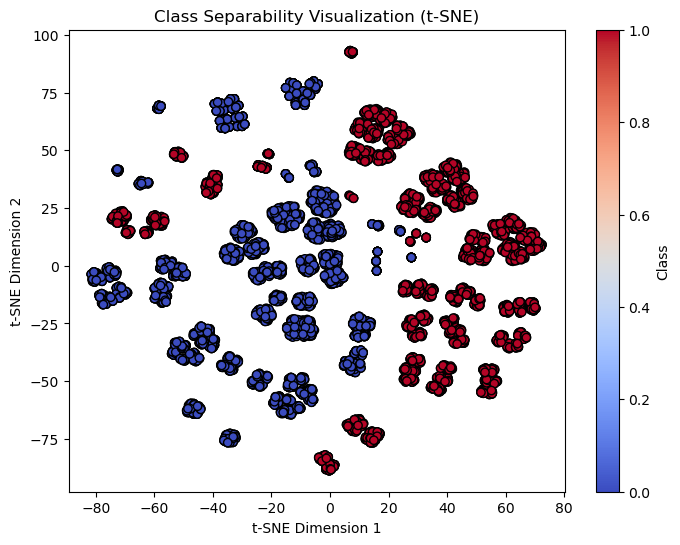

In [83]:
from sklearn.manifold import TSNE

# Step 4: Visualize class separability using t-SNE
# Reduce data to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_train_scaled_final)

# Plot the t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_final, cmap=plt.cm.coolwarm, edgecolors='k')
plt.title("Class Separability Visualization (t-SNE)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Class")
plt.show()

This visualization provides insights into the class separability in the dataset, where the t-SNE algorithm reduces the high-dimensional data to a two-dimensional space to represent its structure. Below are the observations and insights based on the plot:

1. Class Distribution
* Two classes are color-coded: Blue points represent Class 0 (edible). Red points represent Class 1 (poisonous).
* The plot shows clusters of points for each class, indicating how well-separated the classes are in the high-dimensional feature space.

2. Clustering and Separation
* The t-SNE algorithm attempts to preserve the local and global relationships between data points in high-dimensional space:
* Clear clusters are visible for both classes.
* Class 0 (blue) and Class 1 (red) occupy distinct regions in the plot, suggesting good class separability.
* There are some regions where clusters are closer, indicating potential overlap or ambiguity in the data.

3. Overlapping Regions
* While the classes are mostly well-separated, there are some areas where red and blue points are in close proximity or overlap:
* These regions might represent ambiguous samples that could be harder for a classifier to distinguish.
* These points could correspond to noisy data, feature overlap, or samples near the decision boundary.

4. Local Structures
* Clusters within classes: Smaller clusters within the same class indicate sub-groups or patterns in the data that may share similarities.
* This could suggest the presence of latent subcategories or specific feature distributions within each class.

5. Role of t-SNE Parameters
* Perplexity (30): Controls the balance between local and global data structure in the t-SNE embedding. Here, the perplexity seems to provide a good balance, as the clusters are clear but not overly fragmented.
* Iteration count (1000): Ensures the algorithm has converged, leading to a stable representation of the data.

6. Practical Implications
* Classifier Performance: The clear separation between clusters suggests that a classifier might perform well, as the classes are largely distinguishable.
* Ambiguous Points: The overlap regions indicate areas where the model might struggle, and additional feature engineering or data cleaning might help.
* Insights for Feature Space: t-SNE highlights the underlying structure of the data, suggesting that the feature space captures meaningful distinctions between the classes.

---

In [85]:
# Feature Importance

from sklearn.decomposition import PCA
import pandas as pd

# Fit PCA to scaled data
pca = PCA(n_components=X_train_scaled_final.shape[1])  # Analyze all components
pca.fit(X_train_scaled_final)

# Summarize the explained variance for each component
explained_variance = pca.explained_variance_ratio_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'PCA Component': [f"PC{i+1}" for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance
}).sort_values(by='Explained Variance Ratio', ascending=False)

# Display top 10 features
print(feature_importance_df.head(10))

  PCA Component  Explained Variance Ratio
0           PC1                  0.090856
1           PC2                  0.074328
2           PC3                  0.071703
3           PC4                  0.058883
4           PC5                  0.052669
5           PC6                  0.044286
6           PC7                  0.041546
7           PC8                  0.028691
8           PC9                  0.024009
9          PC10                  0.022304


The Explained Variance Ratio indicates how much variance each PCA component captures.

Components with the highest variance contribution indicate the most influential combinations of original features.

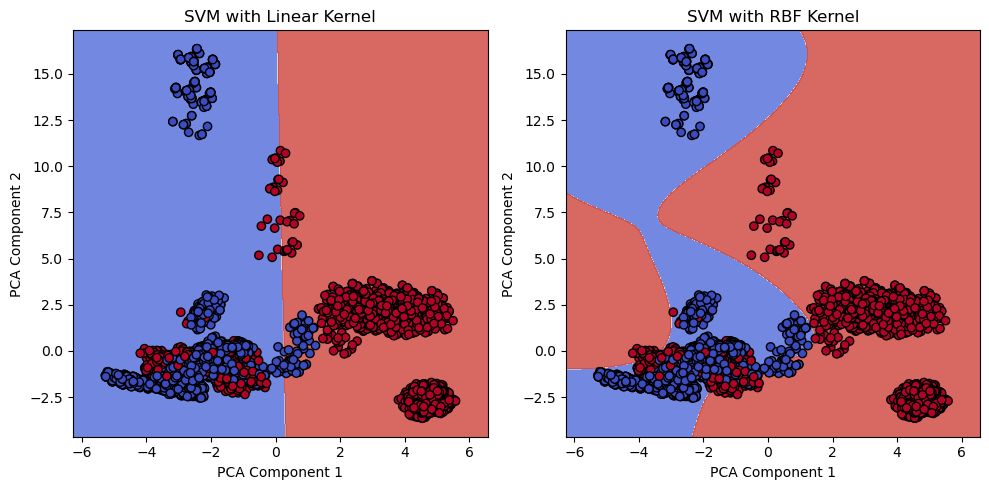

In [87]:
# Kernel Transformation Visualization

from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Train SVM with a linear kernel
svm_linear = SVC(kernel='linear', random_state=42)
svm_linear.fit(X_train_pca, y_train_final)

# Train SVM with an RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)
svm_rbf.fit(X_train_pca, y_train_final)

# Create a mesh grid for both models
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# Predict on the grid for linear kernel
Z_linear = svm_linear.predict(np.c_[xx.ravel(), yy.ravel()])
Z_linear = Z_linear.reshape(xx.shape)

# Predict on the grid for RBF kernel
Z_rbf = svm_rbf.predict(np.c_[xx.ravel(), yy.ravel()])
Z_rbf = Z_rbf.reshape(xx.shape)

# Plot decision boundaries for linear kernel
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z_linear, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_final, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title("SVM with Linear Kernel")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Plot decision boundaries for RBF kernel
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z_rbf, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_final, edgecolors='k', cmap=plt.cm.coolwarm)
plt.title("SVM with RBF Kernel")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()

This visualization shows that our decision to run an SVM model with an RBF kernel captures the variation in the dataset better than an SVM with a linear kernel.

---

# Random Forest Model

## 1. Loading and Preprocessing Data

In [35]:
# Make a copy of the dataset for the RF model
df_RF = df.copy()

# Remove stalk root null values 
df_RF['stalk-root'] = df_RF['stalk-root'].replace('?', np.nan)
df_RF.dropna(inplace=True)

# Verify if missing values have been handled correctly
missing_values_check = df_RF['stalk-root'].isnull().sum()
unique_values_check = df_RF['stalk-root'].unique()
print("Missing Values", missing_values_check)
print("Unique Values:", unique_values_check)
df_RF.shape

Missing Values 0
Unique Values: ['e' 'c' 'b' 'r']


(5644, 23)

In [37]:
# Encode the target variable ('poisonous') to be numeric
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_RF['poisonous'] = label_encoder.fit_transform(df_RF['poisonous'])
df_RF.head() # 1 if poisonous, 0 if edible

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,1
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,0
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,0
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,1
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,0


In [39]:
# Output the number of rows for each class
print("Original Class Counts:")
print(df_RF['poisonous'].value_counts())

# Balance the dataset by randomly undersampling the edible class 
from sklearn.utils import resample
p = df_RF[df_RF['poisonous'] == 1]
e = df_RF[df_RF['poisonous'] == 0]
e_resampled = resample(e, replace=False, n_samples=2156, random_state=42)
df_RF = pd.concat([p, e_resampled])

# Output the number of rows for each class
print("Balanced Class Counts:")
print(df_RF['poisonous'].value_counts())

Original Class Counts:
poisonous
0    3488
1    2156
Name: count, dtype: int64
Balanced Class Counts:
poisonous
1    2156
0    2156
Name: count, dtype: int64


In [41]:
# Split into X and Y 
X = df_RF.drop(columns=['poisonous'])
y = df_RF['poisonous']

In [43]:
# Encode categorical features 
encoded = pd.get_dummies(X, columns=X.columns.tolist(), drop_first=True)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot = encoder.fit_transform(X)

# Create df with the one-hot encoded columns
one_hot_df = pd.DataFrame(one_hot, columns=encoder.get_feature_names_out(X.columns.tolist()))

# Replace X with the one-hot df
X = one_hot_df.copy()
X.head()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_n,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


---

## 2. Building the Random Forest Model

In [43]:
# Import necessary dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

We will split the data into a training and testing set, with a 70-30 split. Our target variable is the poisonous or edible column.

In [47]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We will build our initial classifier with 100 trees. We will first evaluate this model and then determine if we need to do further parameter tuning to improve its performence. 

In [49]:
# Train and test the initial model
rf = RandomForestClassifier(n_estimators=100, random_state=35)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

# Output the test set accuracy
initial_accuracy = accuracy_score(y_test, rf_predictions)
print("Initial Random Forest Model Test Set Accuracy:", initial_accuracy)

Initial Random Forest Model Test Set Accuracy: 1.0


The initial accuracy is 100%. To further verify that the model is working, we will explore some additional classification performance metrics. 

In [51]:
# Output classification report for Random Forest model
from sklearn.metrics import accuracy_score, classification_report

# Output final results
# Convert the classification report into a DataFrame
classification_report_dict = classification_report(y_test, rf_predictions, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Round metrics to 2 decimal places for better readability
classification_report_df = classification_report_df.round(2)

classification_report_df

,precision,recall,f1-score,support
0,1.0,1.0,1.0,629.0
1,1.0,1.0,1.0,665.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,1294.0
weighted avg,1.0,1.0,1.0,1294.0


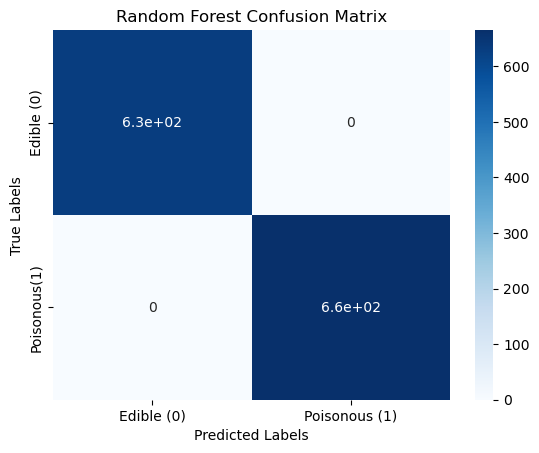

In [53]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xticks(np.arange(0.5,2.5), ['Edible (0)', 'Poisonous (1)'])
plt.yticks(np.arange(0.5,2.5), ['Edible (0)', 'Poisonous(1)'])
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.title("Random Forest Confusion Matrix")
plt.show()

Due to the high accuracy, precision, recall, and f1 scores for both the edible and poisonous classes, model tuning is not necessary. As we see in the confusion matrix, the model did not incorrectly classify any data samples. 

---

## Exploring Random Forest Feature Importance

To get a better sense of how the random forest model is making its decisions, we will take a look at the feature importance. 

In [55]:
# Extract feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)
features = [X.columns[i] for i in indices]
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importances_df

,Feature,Importance
0,veil-type_p,0.002523
1,stalk-color-above-ring_g,0.000098
2,gill-attachment_a,0.000657
3,stalk-color-below-ring_p,0.000230
4,cap-shape_c,0.001022
...,...,...
93,stalk-shape_t,0.002228
94,ring-type_l,0.000706
95,odor_f,0.003032
96,odor_n,0.003006


                    Feature  Importance
0               ring-type_e    0.107789
1                 habitat_l    0.097153
2  stalk-color-below-ring_y    0.077873
3              stalk-root_b    0.044937
4              population_n    0.038053
5               cap-shape_b    0.037785
6               cap-color_g    0.035648
7  stalk-color-above-ring_b    0.034326
8       spore-print-color_w    0.028957
9              population_s    0.028860


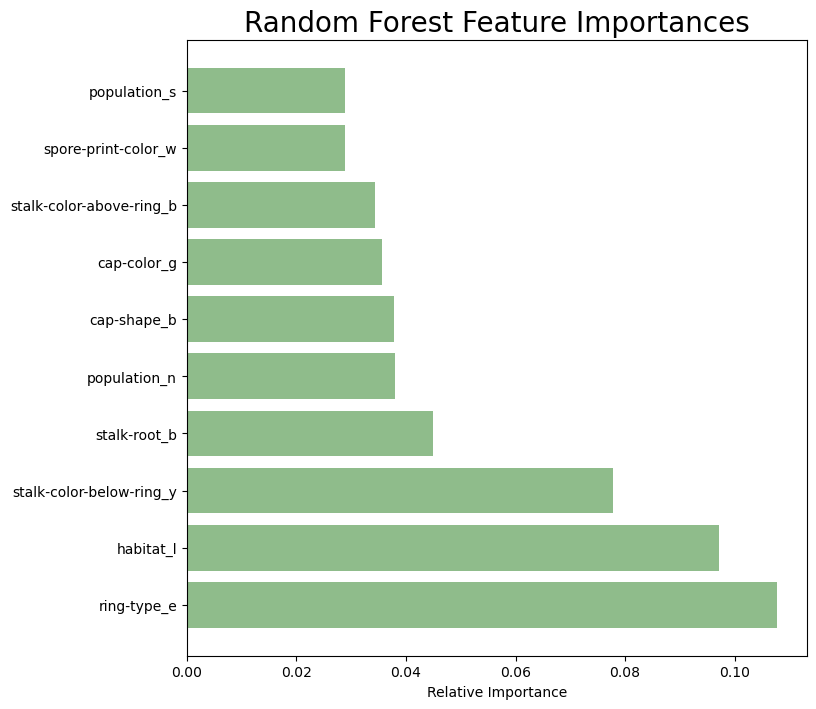

In [57]:
# Extract top 10 importances 
top10 = importances_df.nlargest(n=10, columns=['Importance']).reset_index().drop(['index'], axis=1)
print(top10)

# Plot top 10 importances
plt.figure(figsize=(8, 8))
plt.title('Random Forest Feature Importances', fontsize=20)
plt.barh(top10['Feature'], top10['Importance'], color='#8FBC8B', align='center')
plt.xlabel('Relative Importance')
plt.show()

Top 3 Features with Highest Relative Importance:
* ring-type_e : Evanescent ring type 
* habitat_l : Leaves habitat
* stalk-color-below-ring_y : Yellow stalk color below ring

These features are the most influential features, meaning that their values influence the model's decision making process the most out of all the features. Their relative importances are 0.11, 0.097, and 0.078, respectively. These are not very high values, so we cannot conclude that these features alone can very strongly allow us to classify a mushroom as poisonous or edible. However, checking for these features specifically could be used as a starting point when deciding if a mushroom is poisonous or edible. 

# Logistic Regression Model

## Loading and Preprocessing Data

In [45]:
# Make a copy of the dataset for the binary logistic regression model
df_log = df.copy()

# Remove stalk root null values 
df_log['stalk-root'] = df_log['stalk-root'].replace('?', np.nan)
df_log.dropna(inplace=True)

# Verify if missing values have been handled correctly
missing_values_check = df_log['stalk-root'].isnull().sum()
unique_values_check = df_log['stalk-root'].unique()
print("Missing Values", missing_values_check)
print("Unique Values:", unique_values_check)

df_log.head()

Missing Values 0
Unique Values: ['e' 'c' 'b' 'r']


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [47]:
### More data cleaning! ###
# Encode the target variable ('poisonous'): 1 if poisonous, 0 if edible - keep consistent w/ other models
label_encoder = LabelEncoder()
df_log['poisonous'] = label_encoder.fit_transform(df_log['poisonous']) 

# Balance dataset - remove samples from the majority class
counts = df_log['poisonous'].value_counts() # for confirming desired # of data points in each set - 2156

class0 = df_log[df_log['poisonous'] == 0]
class1 = df_log[df_log['poisonous'] == 1]
class0_adj = class0.sample(n=2156)

df_log = pd.concat([class0_adj, class1])
balance_count = df_log['poisonous'].value_counts() # for confirming success

# Split into training/testing
X = df_log.drop('poisonous', axis=1)
X_encoded = pd.get_dummies(X) # all features are categorical, so onoe hot encode
X = X_encoded

Y = df_log['poisonous']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 35)

print(X_train.shape, X_test.shape, '\n',
     Y_train.shape, Y_test.shape) # confirm success - split 70-30

(3018, 98) (1294, 98) 
 (3018,) (1294,)


## Build the Logistic Regression Model

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

fullmodel = LogisticRegression() # initialize full model - will remove features shortly
print('Number of Features:', X.shape[1]) # confirm - 98 features, that's way too much!
rfe = RFE(fullmodel, n_features_to_select = 10) # trim down features to something easily interpretable, like 10
rfe = rfe.fit(X_train, Y_train) # train model but only using 10 features

Number of Features: 98


In [51]:
# Take a look at our features and their importance
features = X.columns
features_df = pd.DataFrame({'Feature': features, 
                         'Ranking': rfe.ranking_})
features_df = features_df.sort_values('Ranking')
features_df.head(25) # looks like first 10 are most important anyway

,Feature,Ranking
21,odor_c,1
80,spore-print-color_h,1
26,odor_p,1
25,odor_n,1
23,odor_l,1
22,odor_f,1
20,odor_a,1
83,spore-print-color_r,1
42,stalk-shape_e,1
87,population_c,1


In [53]:
# Convert rfe object back to the model object type we want, so that we can save coefficients!
selected_ft = X_train.columns[rfe.support_]
X_train_select = X_train[selected_ft] # new "X_train" that only contains the 10 most important features

model = LogisticRegression() # initialize a new model
model.fit(X_train_select, Y_train) # train new model using only selected features

LogisticRegression()

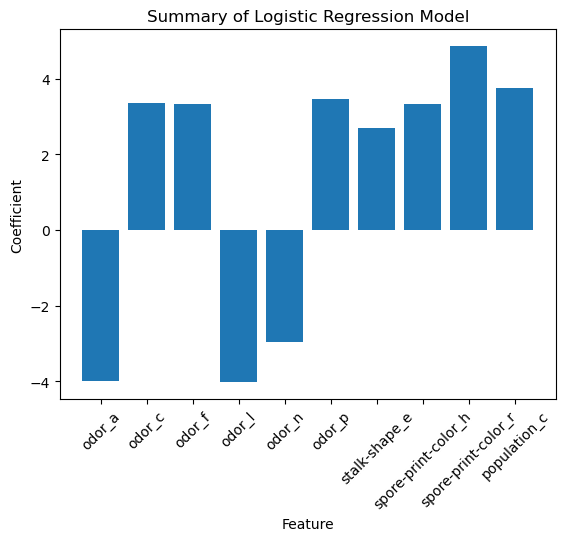

In [59]:
# Visualize model?
coefs = model.coef_
coefs = coefs.flatten()
model_dict = {'Feature': selected_ft,
              'Coefficient': coefs}
model_df = pd.DataFrame(model_dict)

plt.figure()
plt.bar(model_df['Feature'], model_df['Coefficient'])
plt.title('Summary of Logistic Regression Model')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()

In [63]:
# match testing data to training data first
X_test_select = X_test[selected_ft]

Y_pred = model.predict(X_test_select) # make predictions using model

acc = accuracy_score(Y_test, Y_pred) # compare predictions to actual values
print("Accuracy:", acc)

cmatrix = confusion_matrix(Y_test, Y_pred) # another way to evaluate model predictions
print("Confusion Matrix:", '\n', cmatrix)

Accuracy: 1.0
Confusion Matrix: 
 [[666   0]
 [  0 628]]
